# Part 3 - Vocal activity

In this notebook, you'll implement a basic vocal activity detector.  This will build on the exercise in part 2 where you built a silence detector.

## Setup

Again, we begin by setting up our envrionment.  This time, we'll do it all in one block.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
from IPython.display import Audio

In [2]:
# We'll work with an example provided in the repository.
# There are many files in this directory, but we'll start with the first one.
# The later examples (higher numbers) have more difficult noise conditions.

y, sr = librosa.load('detection_examples/voice_detection_1.wav')

In [3]:
# Play it back, so we know what our data sounds like
Audio(data=y, rate=sr)

In [4]:
# Let's visualize the spectrogram to see what the data looks like
D = librosa.stft(y)
S = np.abs(D)
S_db = librosa.amplitude_to_db(S, ref=np.max)

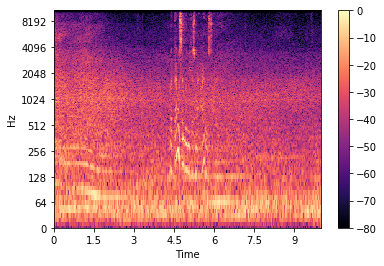

In [5]:
librosa.display.specshow(S_db, x_axis='time', y_axis='log')
plt.colorbar()

# What can we see here?

- Unlike before, there's energy everywhere!
- The background noise is "non-stationary", meaning that its spectrum evolves over time.  Because of this, a simple high-pass filter isn't going to work.
- What else can we do?

### PCEN

As an alternative to decibel scaling, we can use the "per-channel energy normalization" (PCEN) technique.  This was developed by researchers at Google for spotting keywords ("okay google!") in their "Home" product.  It turns out to work well for many problems, but it's particularly good at suppressing complex background noise.

The key idea is to compute a spectrogram, and then compare each time-frequency measurement to the average energy in that frequency over the preceding few time steps.  This will amplify unpredictable changes, which often correspond to speech.

We can compute this by `librosa.pcen`.

In [6]:
S_pcen = librosa.pcen(S)

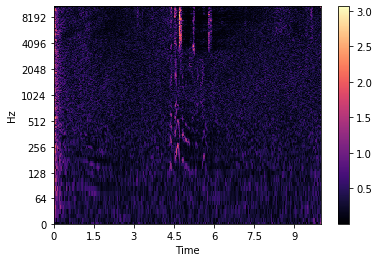

In [7]:
# What does this look like?
librosa.display.specshow(S_pcen, x_axis='time', y_axis='log')
plt.colorbar()

## Interpreting PCEN

PCEN preserves the shape of the spectrogram, but the range of values is quite different.  Unlike the decibel scale, PCEN is always non-negative.

After applying PCEN, we can look at the total normalized energy averaged in each time step.

In [8]:
# This computes the mean along the 0 (first, vertical) axis
pcen_avg = np.mean(S_pcen, axis=0)

In [9]:
# We can then plot the curve just like we did energy in the previous examples
times = librosa.times_like(S_pcen)

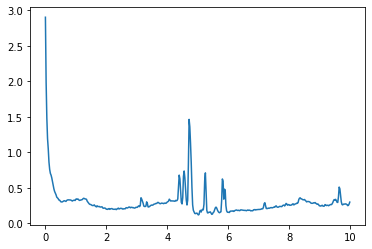

In [10]:
# Now we can plot the data
plt.plot(times, pcen_avg)

# What's going on here?

Remember that PCEN compares each frequency measurement to its previous time steps to determine "novelty".  At the beginning of the signal, there's no history yet, so everything seems novel, hence the large value at `t=0`.

After the filter warms up, you can look at spikes in the `pcen_avg` curve to find points of interest.

We can find those points by using the "onset detection" method `librosa.onset.onset_detect`.  This will try to find peaks in a given curve that are well separated from each other in time.

In [11]:
# we can get event onsets in units of "time"
librosa.onset.onset_detect(onset_envelope=pcen_avg, units='time')

array([0.        , 4.38857143, 4.55111111, 4.71365079, 5.2244898 ,
       5.80498866])

In [12]:
# or in units of "samples". This is useful if you want to slice `y` afterward
onsets = librosa.onset.onset_detect(onset_envelope=pcen_avg, units='samples')

In [13]:
# We'll slice out from the first onset plus one second
y_slice = y[onsets[2]:onsets[2]+sr]

In [14]:
Audio(data=y_slice, rate=sr)

# Hmmm....

Maybe some filtering can still help here!

### Noise!

These signals have a lot of energy in the low frequencies.

Let's use scipy to filter out the high frequencies.

In [15]:
import scipy.signal

In [16]:
# We'll make a band-pass, order-6 butterworth filter
# Human voice lives principally in the range 300-3000 Hz
# We can filter down to just that range, and reduce noise from other sources

b, a = scipy.signal.butter(6, [300, 3000], btype='bandpass', fs=sr)

# Now that we have our coefficients, we can filter the signal
y_low = scipy.signal.filtfilt(b, a, y)

In [17]:
# Let's listen to our output
Audio(data=y_low, rate=sr)

In [18]:
# Now let's compute the spectrogram again and plot it
D_low = librosa.stft(y_low)
S_low = np.abs(D_low)
S_low_pcen = librosa.pcen(S_low)

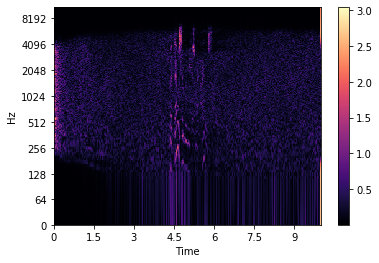

In [19]:
librosa.display.specshow(S_low_pcen, x_axis='time', y_axis='log')
plt.colorbar()

# That looks a little better...


But pure PCEN is not going to solve the entire problem for us.  
Maybe we can do something better than just detecting onsets?

Let's try to group frames by similar timbre.  We'll do this in two steps.

First, we'll extract the "Mel Frequency Cepstral Coefficients" (MFCCs) from each frame of audio.  These represent the coarse shape of a spectrum without being too sensitive to pitch, and are a good first step for trying to capture timbre.

Second, after we have the MFCC's, we'll put them into a clustering model to group them into two "clusters", which should correspond to "voice" and "not voice".

In [20]:
# MFCC's are calculated by the mfcc function in librosa.feature:

mfcc = librosa.feature.mfcc(y=y, sr=sr)

In [21]:
# While we're at it, let's apply it to the filtered signal as well

mfcc_low = librosa.feature.mfcc(y=y_low, sr=sr)

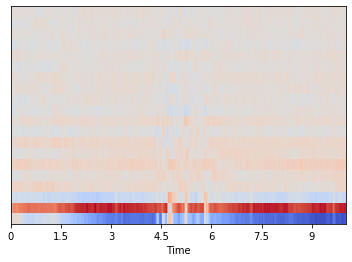

In [22]:
# What do they look like?
librosa.display.specshow(mfcc, x_axis='time')

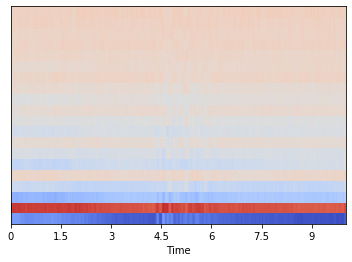

In [23]:
librosa.display.specshow(mfcc_low, x_axis='time')

# Hard to see with human eyes

But machines might do better!

Let's now try to cluster the frames.

In [24]:
# For this, we'll need the "cluster" module from scikit-learn
import sklearn.cluster

In [25]:
# We'll build a K-means clusterer
# With n_clusters=2, this groups each frame into one of two "clusters"
# Hopefully, one cluster will get voice and one will get everything else!
Kmeans = sklearn.cluster.KMeans(n_clusters=2)

# Building the clusterer doesn't do anything yet.  We need to fit it to data.
# scikit-learn expects each data sample to be a row of the matrix, so we have
# to transpose our data by saying ".T"

clusters = Kmeans.fit_predict(mfcc.T)

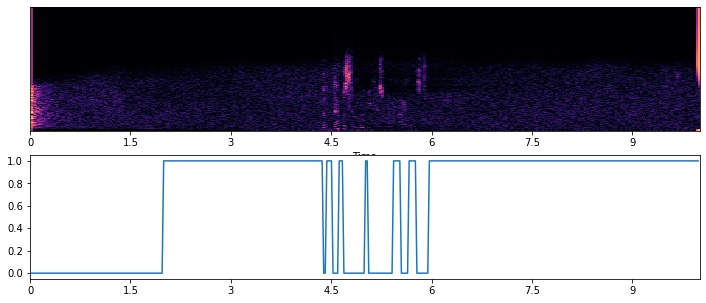

In [26]:
# This cell will make two plots with a common time axis
# This is handy for visualizing aligned features

plt.figure(figsize=(12, 5))
axes = plt.subplot(2,1,1)
librosa.display.specshow(S_low_pcen, x_axis='time')
plt.subplot(2,1,2, sharex=axes)
plt.plot(times, clusters)

In [27]:
# There's some information here, but it could be better.
# Let's look at the band-filtered signal instead

Kmeans_band = sklearn.cluster.KMeans(n_clusters=2)

clusters = Kmeans.fit_predict(mfcc_low.T)

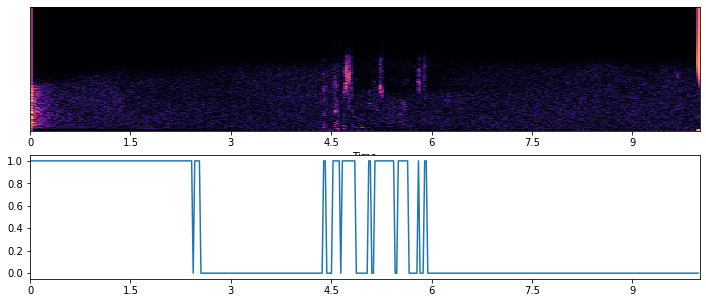

In [28]:
# This cell will make two plots with a common time axis
# This is handy for visualizing aligned features

plt.figure(figsize=(12, 5))
axes = plt.subplot(2,1,1)
librosa.display.specshow(S_low_pcen, x_axis='time')
plt.subplot(2,1,2, sharex=axes)
plt.plot(times, clusters)

In [29]:
# Much more stable.  We can do even better by adding some temporal context
# The above was classifying each frame independently, but we can stack neighboring
# frames together to get a bit more information

mfcc_stack = librosa.feature.stack_memory(mfcc_low)

In [30]:
Kmeans_band = sklearn.cluster.KMeans(n_clusters=2)

clusters = Kmeans.fit_predict(mfcc_stack.T)

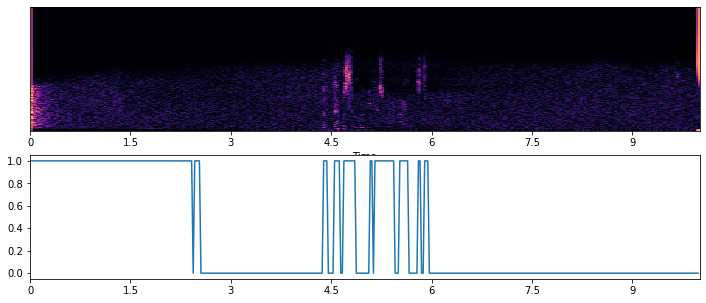

In [31]:
# This cell will make two plots with a common time axis
# This is handy for visualizing aligned features

plt.figure(figsize=(12, 5))
axes = plt.subplot(2,1,1)
librosa.display.specshow(S_low_pcen, x_axis='time')
plt.subplot(2,1,2, sharex=axes)
plt.plot(times, clusters)

# Okay, what now?

We have a detector that works pretty well, and there are many ways to improve this process.

But how can we use the cluster assignments?

### First question:

When does the signal transition from one cluster to the other?  These are the "change points".

We can find these with a few `numpy` operations.

In [32]:
# Where are the frames such that
#   clusters[t] != clusters[t+1] ?
#
# We can only check this up to the second-to-last frame
# In slice notation,
#     [:-1] means "all but the last"
#     [1:] means "all but the first"
#
# np.where will give us a list of indices that satisfy the condition we're interested in
# note: it will actually produce a list of *lists* of indices, one for each dimension
#       since we only have one dimension here (time), we can just take the first element

np.where(clusters[:-1] != clusters[1:])

(array([104, 105, 109, 188, 191, 195, 199, 201, 209, 218, 220, 221, 234,
        237, 243, 249, 251, 253, 256]),)

In [33]:
changes = np.where(clusters[:-1] != clusters[1:])[0]

In [34]:
# This array will contain the frame indices of each change point
changes

array([104, 105, 109, 188, 191, 195, 199, 201, 209, 218, 220, 221, 234,
       237, 243, 249, 251, 253, 256])

In [35]:
# We can convert them to sample indices:
change_samples = librosa.frames_to_samples(changes)

# Or to time indices in seconds:
change_time = librosa.frames_to_time(changes)

In [36]:
change_time

array([2.41487528, 2.43809524, 2.53097506, 4.36535147, 4.43501134,
       4.52789116, 4.62077098, 4.66721088, 4.85297052, 5.06195011,
       5.10839002, 5.13160998, 5.43346939, 5.50312925, 5.64244898,
       5.78176871, 5.82820862, 5.87464853, 5.94430839])

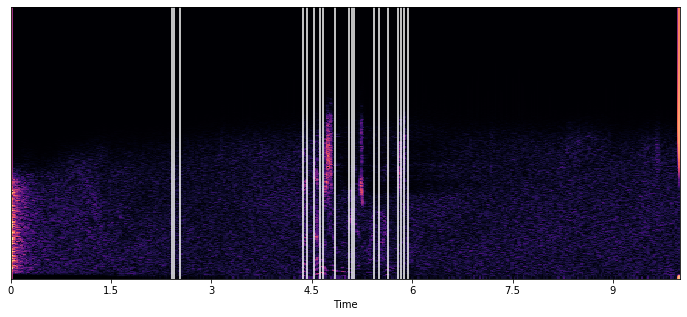

In [37]:
# Once we have the change-points in time, we can plot markers on top of the spectrogram
plt.figure(figsize=(12, 5))
librosa.display.specshow(S_low_pcen, x_axis='time')

# Make vertical lines, positioned at the change times,
# starting at 0 Hz and going all the way up to sr/2
# and color them white
plt.vlines(change_time, 0, sr/2, color='w')

# Summary

What have we done in this notebook?

1. Worked with complex acoustic scenes
2. Used PCEN to more clearly visualize the contents of the sound
3. Used a band-pass filter to focus on human vocal range
4. Extracted timbral features
5. Clustered the features to separate "voice" from "not voice"
6. Detected change-points in the signal, and inferred time markers

What could we do next? Some ideas:

- Source separation: can we remove noise that interferes with voice?
- Temporally constrained detection: can we make more locally contiguous detections?
- Modeling larger collections: this might work for one speaker, but what about more generally?